In [2]:
import os
import glob
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython import display

from keras import layers
from keras import models

import seaborn as sns

2024-04-24 15:41:00.217284: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-24 15:41:01.093761: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-24 15:41:01.105278: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-24 15:41:03.849090: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
tf.keras.utils.set_random_seed(seed)

In [4]:
data_dir = "/home/masikol/main/Organization_of_data_processing/Labs/Voice-detection/mini_speech_commands"

In [5]:
commands = np.array(os.listdir(data_dir))
print(commands)

['right' 'left' 'stop' 'down' 'go' 'up']


In [6]:
filenames_pattern = data_dir + '/*/*'
filenames = glob.glob(filenames_pattern, recursive=True)

In [7]:
!pwd

/home/masikol/main/Organization_of_data_processing/Labs/Voice-detection


In [8]:
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of samples: ', num_samples)
print('Number of samples per class: ', num_samples//len(commands))
filenames[0]

Number of samples:  6000
Number of samples per class:  1000


<tf.Tensor: shape=(), dtype=string, numpy=b'/home/masikol/main/Organization_of_data_processing/Labs/Voice-detection/mini_speech_commands/go/918a2473_nohash_0.wav'>

In [9]:
train_files = filenames[:4800]
val_files = filenames[4800: 4800 + 600]
test_files = filenames[-600:]

print('Train size:', len(train_files))
print('Validation size:', len(val_files))
print('Test size:', len(test_files))

Train size: 4800
Validation size: 600
Test size: 600


In [10]:
test_file = tf.io.read_file(filenames[0])
test_audio, _ = tf.audio.decode_wav(contents=test_file)
test_audio.shape

TensorShape([16000, 1])

In [11]:
def decode_audio(audio_binary):
    audio, _ = tf.audio.decode_wav(contents=audio_binary)
    return tf.squeeze(audio, axis=-1)

In [12]:
decode_audio(test_file)

<tf.Tensor: shape=(16000,), dtype=float32, numpy=
array([-0.00369263, -0.00543213, -0.00628662, ..., -0.0057373 ,
       -0.00579834, -0.00506592], dtype=float32)>

In [13]:
def get_label(file_path):
    parts = tf.strings.split(
    input=file_path,
    sep=os.path.sep)
    return parts[-2]

In [14]:
get_label(filenames[0])

<tf.Tensor: shape=(), dtype=string, numpy=b'go'>

In [15]:
def get_waveform_and_label(file_path):
    label = get_label(file_path)
    audio_binary = tf.io.read_file(file_path)
    waveform = decode_audio(audio_binary)
    return waveform, label

In [16]:
get_waveform_and_label(filenames[0])

(<tf.Tensor: shape=(16000,), dtype=float32, numpy=
 array([-0.00369263, -0.00543213, -0.00628662, ..., -0.0057373 ,
        -0.00579834, -0.00506592], dtype=float32)>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'go'>)

In [17]:
AUTOTUNE = tf.data.AUTOTUNE

files_ds = tf.data.Dataset.from_tensor_slices(train_files)

In [18]:
waveform_ds = files_ds.map(
    map_func = get_waveform_and_label,
    num_parallel_calls=AUTOTUNE
)

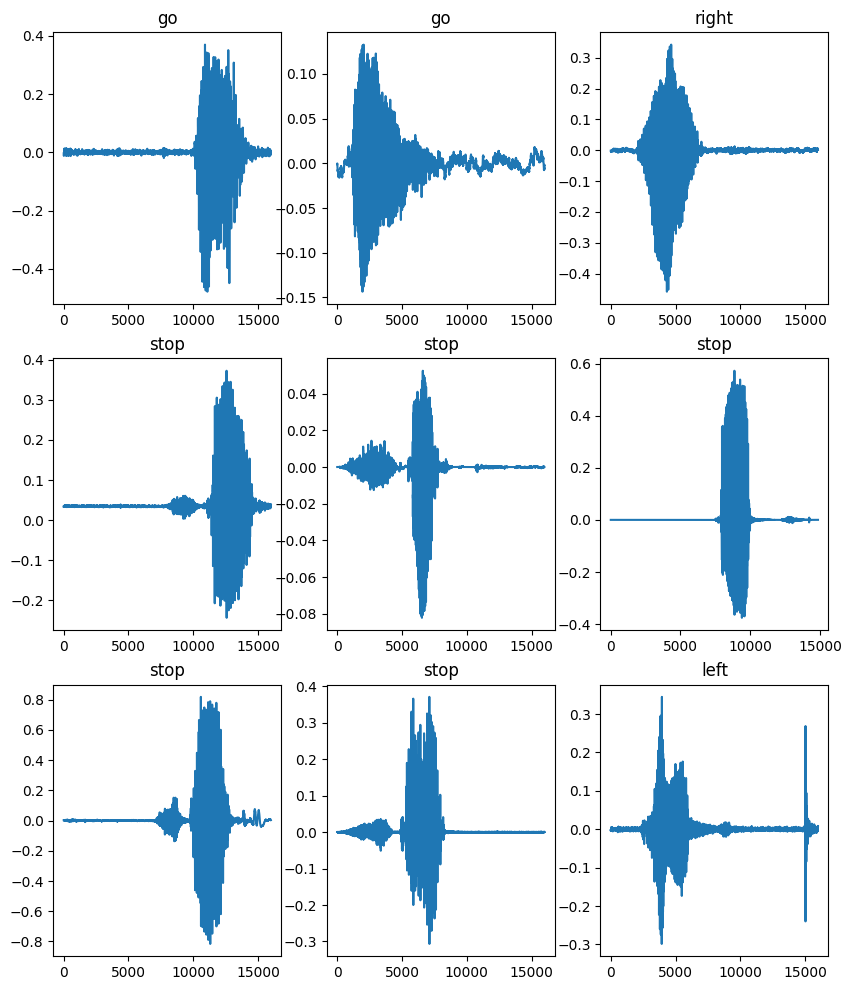

In [19]:
rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))

for i, (audio, label) in enumerate(waveform_ds.take(n)):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    ax.plot(audio.numpy())
    label = label.numpy().decode('utf-8')
    ax.set_title(label)

plt.savefig('waveform_plot.jpeg')
plt.show()

In [20]:
def get_spectrogram(waveform):
    input_len = 16000
    waveform = waveform[:input_len]
    zero_padding = tf.zeros(
        [input_len] - tf.shape(waveform),
        dtype=tf.float32)
    waveform = tf.cast(waveform, dtype=tf.float32)
    equal_length = tf.concat([waveform, zero_padding], 0)
    spectrogram = tf.signal.stft(
        equal_length, frame_length=255, frame_step=128)
    spectrogram = tf.abs(spectrogram)
    spectrogram = spectrogram[..., tf.newaxis]
    return spectrogram

In [21]:
for waveform, label in waveform_ds.take(1):
  label = label.numpy().decode('utf-8')
  spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=16000))

Label: go
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


In [22]:
def plot_spectrogram(spectrogram, ax):
    if len(spectrogram.shape) > 2:
        assert len(spectrogram.shape) == 3
        spectrogram = np.squeeze(spectrogram, axis=-1)
    log_spec = np.log(spectrogram.T + np.finfo(float).eps)
    height = log_spec.shape[0]
    width = log_spec.shape[1]
    X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
    Y = range(height)
    ax.pcolormesh(X, Y, log_spec)

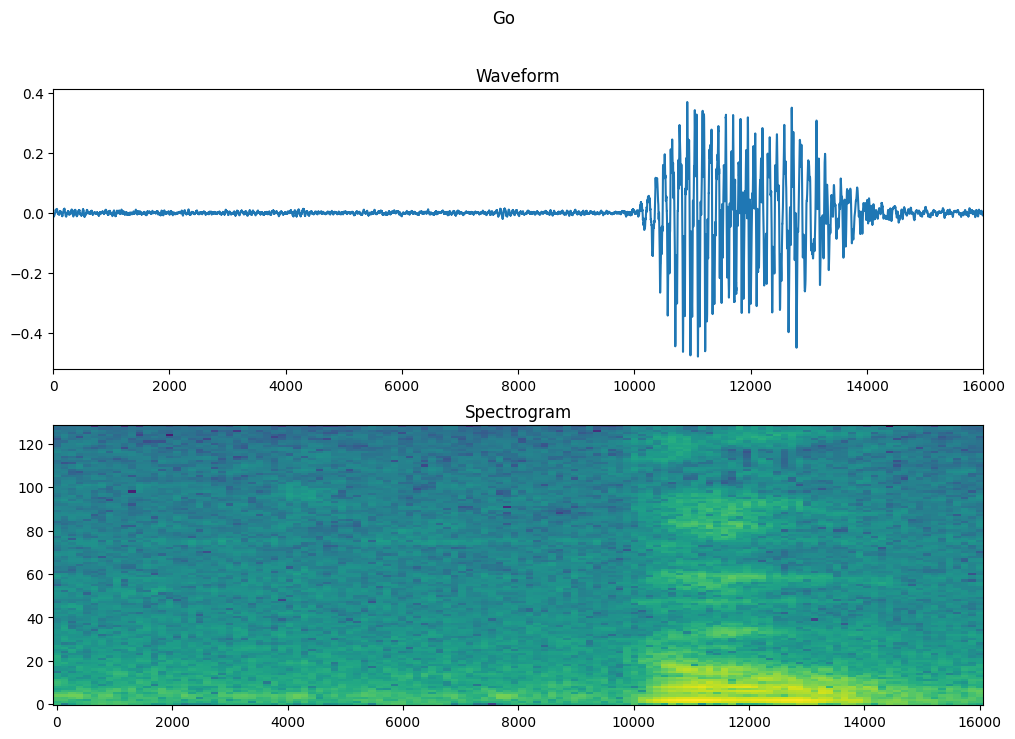

In [23]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')

fig.suptitle(label.capitalize())

plt.savefig('waveform_and_spectrogram.jpeg')
plt.show()

In [24]:
def get_spectrogram_and_label_id(audio, label):
    spectrogram = get_spectrogram(audio)
    label_id = tf.argmax(label == commands)
    return spectrogram, label_id

In [25]:
spectrogram_ds = waveform_ds.map(
    map_func=get_spectrogram_and_label_id,
    num_parallel_calls=AUTOTUNE)


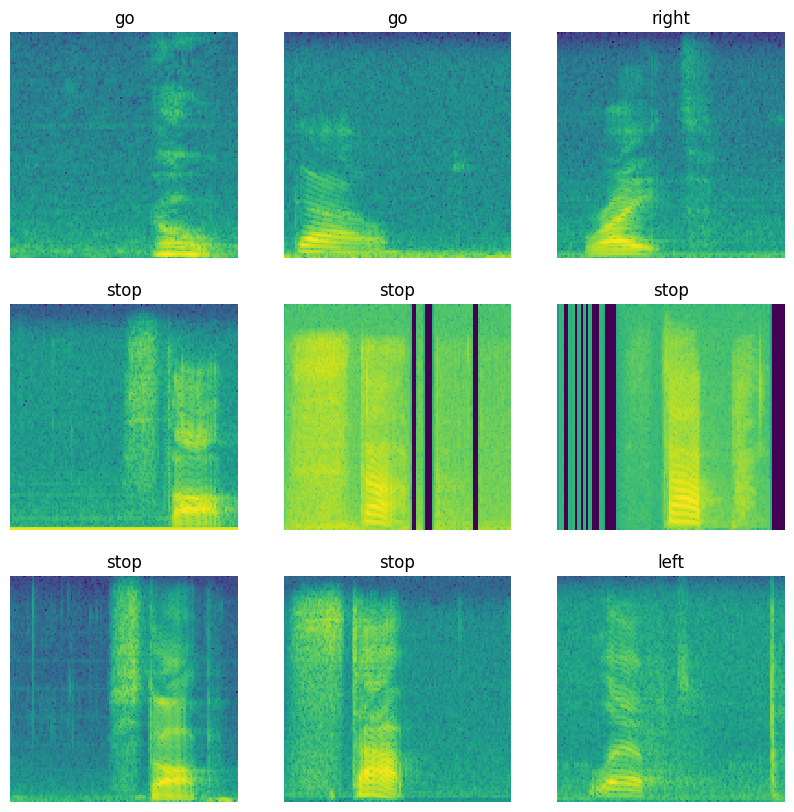

In [26]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))

for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(spectrogram.numpy(), ax)
    ax.set_title(commands[label_id.numpy()])
    ax.axis('off')
plt.savefig('spectrogram_plot.jpeg')
plt.show()

In [27]:
def preprocess_dataset(files):
    print(files)
    files_ds = tf.data.Dataset.from_tensor_slices(files)
    print(files_ds)
    output_ds = files_ds.map(
        map_func = get_waveform_and_label,
        num_parallel_calls=AUTOTUNE)
    print(output_ds)
    output_ds = output_ds.map(
        map_func = get_spectrogram_and_label_id,
        num_parallel_calls=AUTOTUNE)
    print(output_ds)
    return output_ds

In [28]:
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

tf.Tensor(
[b'/home/masikol/main/Organization_of_data_processing/Labs/Voice-detection/mini_speech_commands/left/422d3197_nohash_0.wav'
 b'/home/masikol/main/Organization_of_data_processing/Labs/Voice-detection/mini_speech_commands/stop/97f4c236_nohash_2.wav'
 b'/home/masikol/main/Organization_of_data_processing/Labs/Voice-detection/mini_speech_commands/down/6cc28ce5_nohash_0.wav'
 b'/home/masikol/main/Organization_of_data_processing/Labs/Voice-detection/mini_speech_commands/left/c6ee87a7_nohash_0.wav'
 b'/home/masikol/main/Organization_of_data_processing/Labs/Voice-detection/mini_speech_commands/go/cb8f8307_nohash_3.wav'
 b'/home/masikol/main/Organization_of_data_processing/Labs/Voice-detection/mini_speech_commands/down/1942abd7_nohash_0.wav'
 b'/home/masikol/main/Organization_of_data_processing/Labs/Voice-detection/mini_speech_commands/left/c392e01d_nohash_1.wav'
 b'/home/masikol/main/Organization_of_data_processing/Labs/Voice-detection/mini_speech_commands/down/bbd0bbd0_nohash_3.wav'

In [29]:
batch_size = 32
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

In [30]:
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

In [31]:
for spectrogram, _ in train_ds.take(1):
    input_shape = spectrogram.shape[1:]
num_labels = len(commands)

2024-04-24 15:41:16.973781: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [32]:
print('Input shape: ', input_shape)
print('Number classes: ', num_labels)

Input shape:  (124, 129, 1)
Number classes:  6


In [33]:
norm_layer = layers.Normalization()
norm_layer.adapt(data = spectrogram_ds.map(map_func = lambda spec, label: spec))

In [34]:
model = models.Sequential([
    layers.Input(shape = input_shape),
    layers.Resizing(92, 92),
    norm_layer,
    layers.BatchNormalization(),
    layers.Conv2D(32, (3, 3), padding = 'same', activation = 'elu'),
    layers.MaxPool2D(pool_size = (2, 2)),
    layers.Dropout(0.1),
    layers.BatchNormalization(),
    layers.Conv2D(32, (3, 3), padding = 'same', activation = 'elu'),
    layers.MaxPool2D(pool_size = (2, 2)),
    layers.Dropout(0.1),
    layers.BatchNormalization(),
    layers.Flatten(),
    layers.Dense(256, activation = 'elu'),
    layers.Dropout(0.1),
    layers.Dense(num_labels, activation = 'softmax'),
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 92, 92, 1)         0         
                                                                 
 normalization (Normalizati  (None, 92, 92, 1)         3         
 on)                                                             
                                                                 
 batch_normalization (Batch  (None, 92, 92, 1)         4         
 Normalization)                                                  
                                                                 
 conv2d (Conv2D)             (None, 92, 92, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 46, 46, 32)        0         
 D)                                                              
                                                        

In [35]:
model.compile(
    optimizer = tf.keras.optimizers.Nadam(),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
    metrics = ['accuracy'],
)

In [36]:
import keras

In [37]:
EPOCHS = 25
history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = EPOCHS,
    callbacks = [tf.keras.callbacks.EarlyStopping(verbose = 1, patience = 5),
                 keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', patience = 3, verbose = True)],
)

Epoch 1/25


/home/masikol/.local/lib/python3.10/site-packages/keras/src/backend.py:5714: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


150/150 [==============================] - 65s 406ms/step - loss: 1.3886 - accuracy: 0.5975 - val_loss: 1.7051 - val_accuracy: 0.2600 - lr: 0.0010
Epoch 2/25
150/150 [==============================] - 48s 323ms/step - loss: 0.5196 - accuracy: 0.8225 - val_loss: 1.1408 - val_accuracy: 0.5067 - lr: 0.0010
Epoch 3/25
150/150 [==============================] - 47s 310ms/step - loss: 0.2710 - accuracy: 0.9035 - val_loss: 0.7322 - val_accuracy: 0.7633 - lr: 0.0010
Epoch 4/25
150/150 [==============================] - 51s 342ms/step - loss: 0.2070 - accuracy: 0.9267 - val_loss: 0.7854 - val_accuracy: 0.7550 - lr: 0.0010
Epoch 5/25
150/150 [==============================] - 47s 315ms/step - loss: 0.1769 - accuracy: 0.9392 - val_loss: 0.7462 - val_accuracy: 0.8050 - lr: 0.0010
Epoch 6/25
150/150 [==============================] - 52s 343ms/step - loss: 0.1256 - accuracy: 0.9585 - val_loss: 0.7101 - val_accuracy: 0.8233 - lr: 0.0010
Epoch 7/25
150/150 [==============================] - 52s 345ms

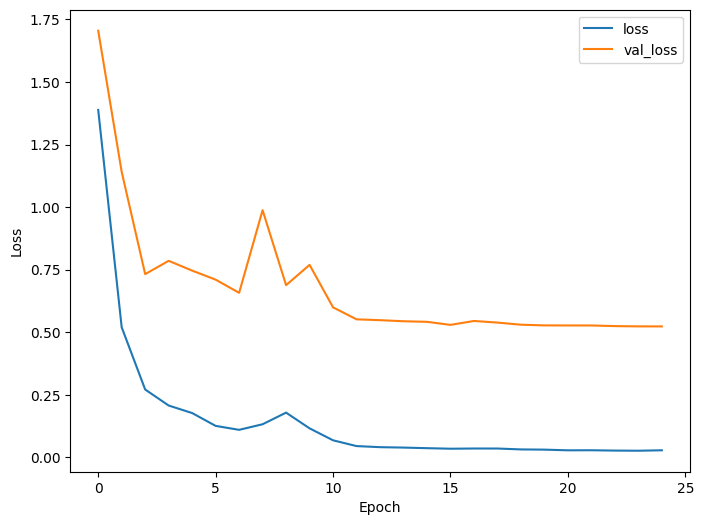

In [38]:
metrics = history.history
plt.figure(figsize = (8, 6))
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['loss', 'val_loss'])
plt.savefig('metrics_plot.jpeg')
plt.show()

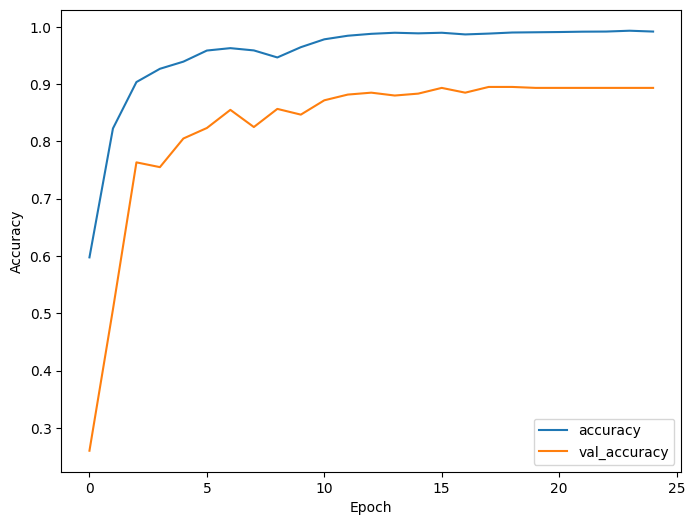

In [39]:
plt.figure(figsize = (8, 6))
plt.plot(history.epoch, metrics['accuracy'], metrics['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['accuracy', 'val_accuracy'])
plt.savefig('metrics_accuracy_plot.jpeg')
plt.show()

In [40]:
test_audio = []
test_labels = []

for audio, label in test_ds:
    test_audio.append(audio.numpy())
    test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [47]:
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

19/19 [==============================] - 2s 108ms/step
Test set accuracy: 94%


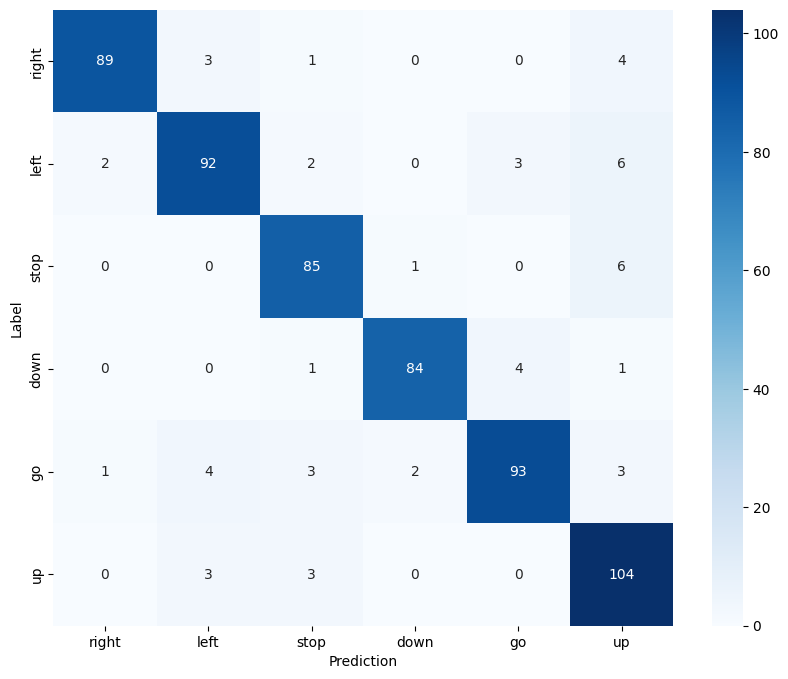

In [42]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize = (10, 8))
sns.heatmap(confusion_mtx,
            xticklabels = commands,
            yticklabels = commands,
            annot = True, fmt = 'g',
            cmap = 'Blues')

plt.xlabel('Prediction')
plt.ylabel('Label')

plt.savefig('confusion_matrix.jpeg')

plt.show()

tf.Tensor(
[[6.2858968e-11 1.3396603e-07 3.0118536e-05 1.6290616e-05 9.9890208e-01
  1.0513875e-03]], shape=(1, 6), dtype=float32)


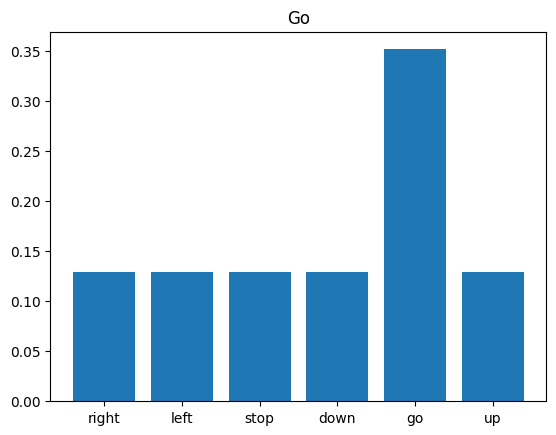

In [43]:
x = data_dir + '/go/0d53e045_nohash_1.wav'
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis,...]

prediction = model(x)
print(prediction)
x_labels = commands
plt.bar(x_labels, tf.nn.softmax(prediction[0]))
plt.title('Go')
plt.savefig('network_output.jpeg')

plt.show()

display.display(display.Audio(waveform, rate=16000))

In [44]:
model.save("model.h5")

/home/masikol/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
